In [1]:
import numpy as np
from pandas.core.frame import DataFrame
import forces
from scipy.integrate import odeint
from scipy.stats import maxwell 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<h2 style="color:orange">Function to create N randomized particles</h2>

Average mass = D*V = 2e-6 * (4 * pi* (7.5e-7)**3)/3
tao = sqrt(lambda * Average Mass / A(l,n,p)) =  sqrt(2*Pi/k * Average Mass / 7.02158e-14)
Average velocity = 4KbT / 3M

In [2]:
lambd = 2*np.pi*39.107/(5.6e-5)
M = 2e-6 * (4 * np.pi* (7.5e-7)**3)/3
tao = 0.00048528
kbt = 1.38064852e-23 * 300 
vavg = (4*kbt) / (3*M)
vavgTilda = tao*vavg/lambd #1040kg/m^3

In [36]:
def randomized(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    eta = (0.00700175)/(vavgTilda*6*np.pi*(7.5*10**(-7)))#Eta is for Average Rp and Average velocity for all cartesian directions
    while Results.count()[0] != N:
        Rp = np.random.uniform(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8))
        rho = np.random.uniform(39.107,39.107+(2*np.pi))
        theta = np.random.uniform((np.pi-np.sqrt(1/40)),(np.pi+np.sqrt(1/40)))
        phi = np.random.uniform(0,np.pi*2)
        vx = np.random.normal(0,vavgTilda)
        vy = np.random.normal(0,vavgTilda)
        vz = np.random.normal(0,vavgTilda)

#rhop is density, 

        
        gamma = (9*tao*eta)/(2*Rp*rho)#gamma tilde 


        
        dRhodT = vx*np.sin(theta)*np.cos(phi)+vy*np.sin(theta)*np.sin(phi)+vz*np.cos(theta) #vrho 
        if dRhodT <= 0: #try more numbers forward trajectory of one of the particles 
            Results = pd.concat([pd.DataFrame([[vx,vy,vz,rho,theta,phi,dRhodT,0,0,Rp,gamma,None]],columns = Results.columns),Results],ignore_index = True)
    return Results

In [37]:
print(randomized(4))

         rand_x        rand_y        rand_z       rho_    theta_      phi_  \
0  1.129554e-08 -9.717631e-08  3.752542e-08  40.590439  3.249173  2.607208   
1 -3.858588e-07 -1.169883e-07  1.766549e-07  41.628741  3.019926  5.280882   
2  7.970087e-08  1.094309e-07  3.549757e-08  45.011532  3.299391  5.068558   
3 -3.553014e-08 -2.124642e-07  1.859323e-07  43.676904  3.214849  2.052110   

          dRho_ dTheta_ dPhi_           Rp_        gamma_ time_  
0 -3.095054e-08       0     0  7.494504e-07  2.057291e+11  None  
1 -1.885955e-07       0     0  7.340171e-07  2.048155e+11  None  
2 -2.330648e-08       0     0  7.284318e-07  1.908753e+11  None  
3 -1.728538e-07       0     0  7.588439e-07  1.888244e+11  None  


<h2 style="color:deeppink">ODE Solver Function</h2>

In [38]:
TC = []
def f(u, t, par, gamma):
        rho, drho, theta, dtheta, phi, dphi = u
        dudt = [
                drho, forces.rho(rho, theta, par) - gamma * drho + rho * (dtheta * np.cos(phi)) ** 2 + rho * dphi ** 2,
                dtheta, (forces.theta(rho, theta, par) - gamma * rho * dtheta * np.cos(phi) - 2 * drho * dtheta * np.cos(phi) + 2 * rho * dtheta * dphi * np.sin(phi)) / (rho * np.cos(phi)),
                dphi, (forces.phi(rho, theta, par) - gamma * rho * dphi - 2 * drho * dphi - rho * dphi ** 2 * np.sin(phi) * np.cos(phi)) / rho
            ]
        if rho <= 39.107: #and theta <= (np.pi/2 + 0.01) and theta >= (np.pi - 0.01):
            TC.append(t)
            return [None,None,None,None,None,None]
        return dudt

In [39]:

def solve(Results):
    global TC
    j = 0
    time = np.linspace(0,20,100)
    while j != len(F.index):
        gamma_ = Results['gamma_'][j]
        par = {
            'l': 40,
            'x_r': 39.107,            
            'R_ratio': (Results['Rp_'][j])/(5.6*10**(-5)), 
            'n_w': 1.326,
            'n_p': 1.572
            }
        u0 = [Results['rho_'][j],Results['dRho_'][j], Results['theta_'][j], Results['dTheta_'][j], Results['phi_'][j], Results['dPhi_'][j]] 
        sol = odeint(f, u0, time, args = (par, gamma_))
        if len(TC) != 0:
            Results.at[j,'time_'] = TC[0]
            TC = []
        j+=1
    return Results


In [40]:
F = randomized(10)
h = solve(F).dropna()
h = h.sort_values('time_', ascending = True)
print(h)

Empty DataFrame
Columns: [rand_x, rand_y, rand_z, rho_, theta_, phi_, dRho_, dTheta_, dPhi_, Rp_, gamma_, time_]
Index: []


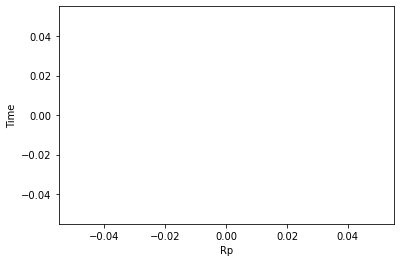

In [16]:
plt.plot(h['Rp_'],h['time_'])
plt.xlabel('Rp')
plt.ylabel('Time')
plt.show()

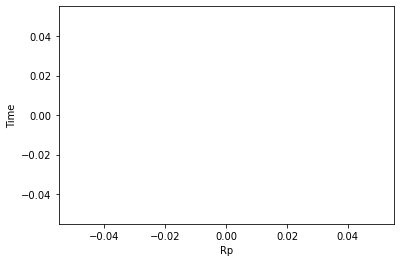

In [ ]:
plt.plot(h['Rp_'],h['time_'])
plt.xlabel('Rp')
plt.ylabel('Time')
plt.show()

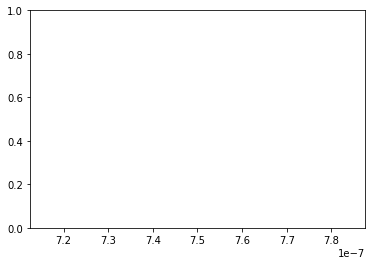

In [ ]:
fig, ax = plt.subplots()
sns.histplot(h['Rp_'], bins = 10, ax = ax)
ax.set_xlim(7.5*10**(-7)-3.75*10**(-8), 7.5*10**(-7)+3.75*10**(-8))
plt.show()